In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import datetime
import warnings
import matplotlib
import utils
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
%load_ext autoreload
%autoreload 2
warnings.filterwarnings("ignore")

# Load data

In [18]:
df = pd.read_parquet('hourly_liquidity_full.parquet')
dfps = pd.read_parquet('hourly_pool_state_full.parquet')
dfp = pd.read_parquet('hourly_liquidity_pricecentered_full.parquet')


# dfp = dfp[dfp['hour'] > datetime.datetime(2022,11,1,0, tzinfo=datetime.timezone.utc)]
# PEG_TICK = 0          
# THRESH = 30

# dfps = dfps.sort_values("hour").copy()
# dfps["abs_dev"] = (PEG_TICK - dfps["poolTick"]).abs()
# flag = dfps["abs_dev"] > THRESH


# 3D plots of temporal evolution

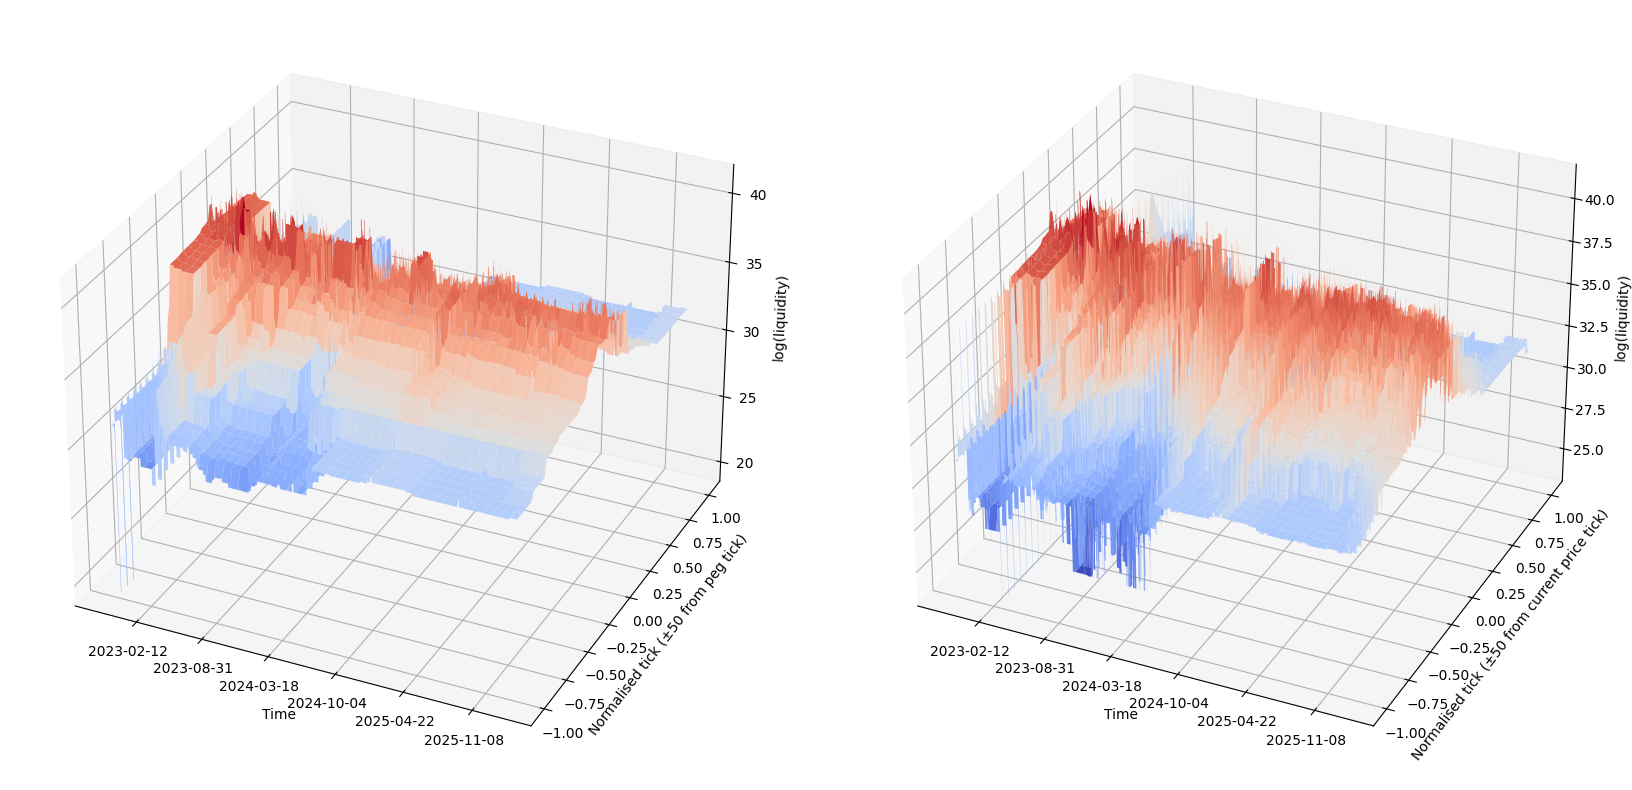

In [19]:

fig, axs = plt.subplots(1,2, figsize=(17, 8),subplot_kw=dict(projection='3d'))
TT = datetime.datetime(2022,11,1,0, tzinfo=datetime.timezone.utc)
# TT_end = datetime.datetime(2023,3,13,0, tzinfo=datetime.timezone.utc)
TT_end = dfp.hour.iloc[-1]
d_pegcentered = utils.plot_liquidity_surface(df,TT, TT_end, centered=True, ax=axs[0])
d_pricecentered = utils.plot_liquidity_surface(dfp,TT, TT_end, centered=False, ax=axs[1])
plt.tight_layout()
plt.savefig('uniswap_liquidity_surface_comparison.png', dpi=300, transparent = True, bbox_inches = 'tight');

# Plot rolling average / standard deviation 

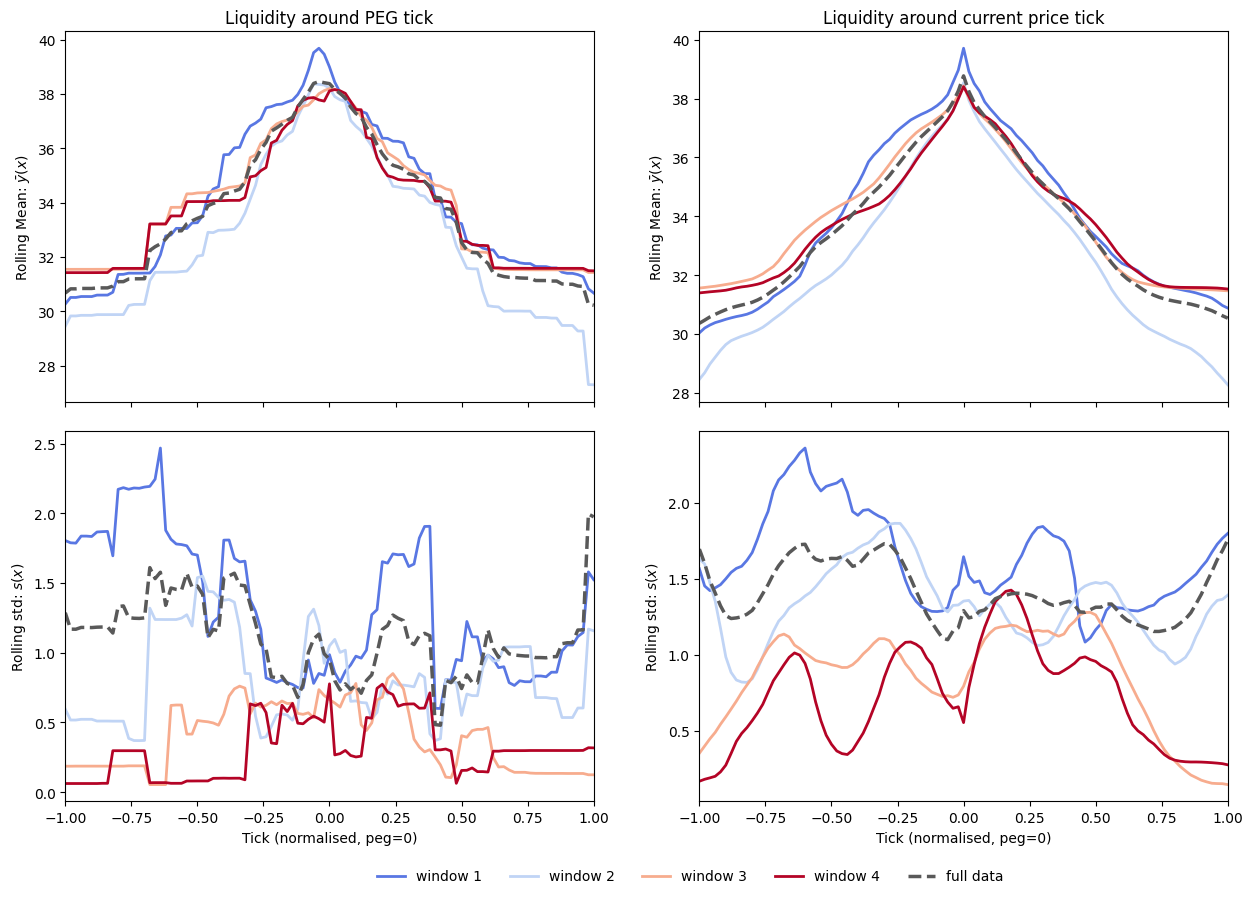

In [20]:
N_WINDOWS = 4    


fig, (ax_mean, ax_std) = plt.subplots(
        2, 2, figsize=(15, 10), sharex=True, gridspec_kw={"hspace": 0.08}
    )       

for k, d in enumerate([d_pegcentered, d_pricecentered]):  # loop over both datasets
    d["timestamp"] = pd.to_datetime(d["timestamp"], utc=True)

    # normalised tick around PEG tick = 0  -> [-1,1]
    d["x"] = d['tick_norm'].astype(float)

    # log liquidity curve (stable with zeros)
    d["y"] = d['logL'].astype(float)

    # ---- define "windows" over time (equal-size partitions); replace with your own date ranges if desired
    d = d.sort_values("timestamp")
    d["window"] = pd.qcut(d["timestamp"].view("int64"), q=N_WINDOWS, labels=[f"window {i+1}" for i in range(N_WINDOWS)])

    # ---- compute sample mean and std as functions of x (normalised tick)
    # full-data stats
    full_stats = d.groupby("x", observed=True)["y"].agg(mean="mean", std="std").reset_index()

    # per-window stats
    win_stats = (d.groupby(["window", "x"], observed=True)["y"]
                .agg(mean="mean", std="std")
                .reset_index())

    # ---- plot (layout like the figure but for ONE pool: mean on top, std on bottom)
    colors = [matplotlib.colormaps['coolwarm'](np.linspace(0.1, 1, 4)[i]) for i in range(4)]

    

    # windows
    for i, w in enumerate(sorted(win_stats["window"].unique())):
        tmp = win_stats[win_stats["window"] == w].sort_values("x")
        ax_mean[k].plot(tmp["x"], tmp["mean"], lw=2, color=colors[i % len(colors)], label=w)
        ax_std[k].plot(tmp["x"], tmp["std"],  lw=2, color=colors[i % len(colors)], label=w)

    # full data (dashed black/grey)
    full_stats = full_stats.sort_values("x")
    ax_mean[k].plot(full_stats["x"], full_stats["mean"], "--", lw=2.5, color="0.35", label="full data")
    ax_std[k].plot(full_stats["x"], full_stats["std"],  "--", lw=2.5, color="0.35", label="full data")

    # styling
    ax_mean[k].set_ylabel(r"Rolling Mean: $\bar{y}(x)$")
    ax_std[k].set_ylabel(r"Rolling std: $s(x)$")
    ax_std[k].set_xlabel("Tick (normalised, peg=0)")
    ax_mean[k].set_title("Liquidity around PEG tick" if k == 0 else "Liquidity around current price tick")
    ax_mean[k].set_xlim(-1, 1)
    ax_mean[k].grid(False)
    ax_std[k].grid(False)
    if k == 0:
        ax_std[k].legend(frameon = False, ncols = 5, bbox_to_anchor=(1.8, -0.15))
plt.savefig('./uniswap_liquidity_rolling_stats.png', dpi=300, transparent = True, bbox_inches = 'tight')

# Rolling FPCA: 1 month window, 24 hours stride

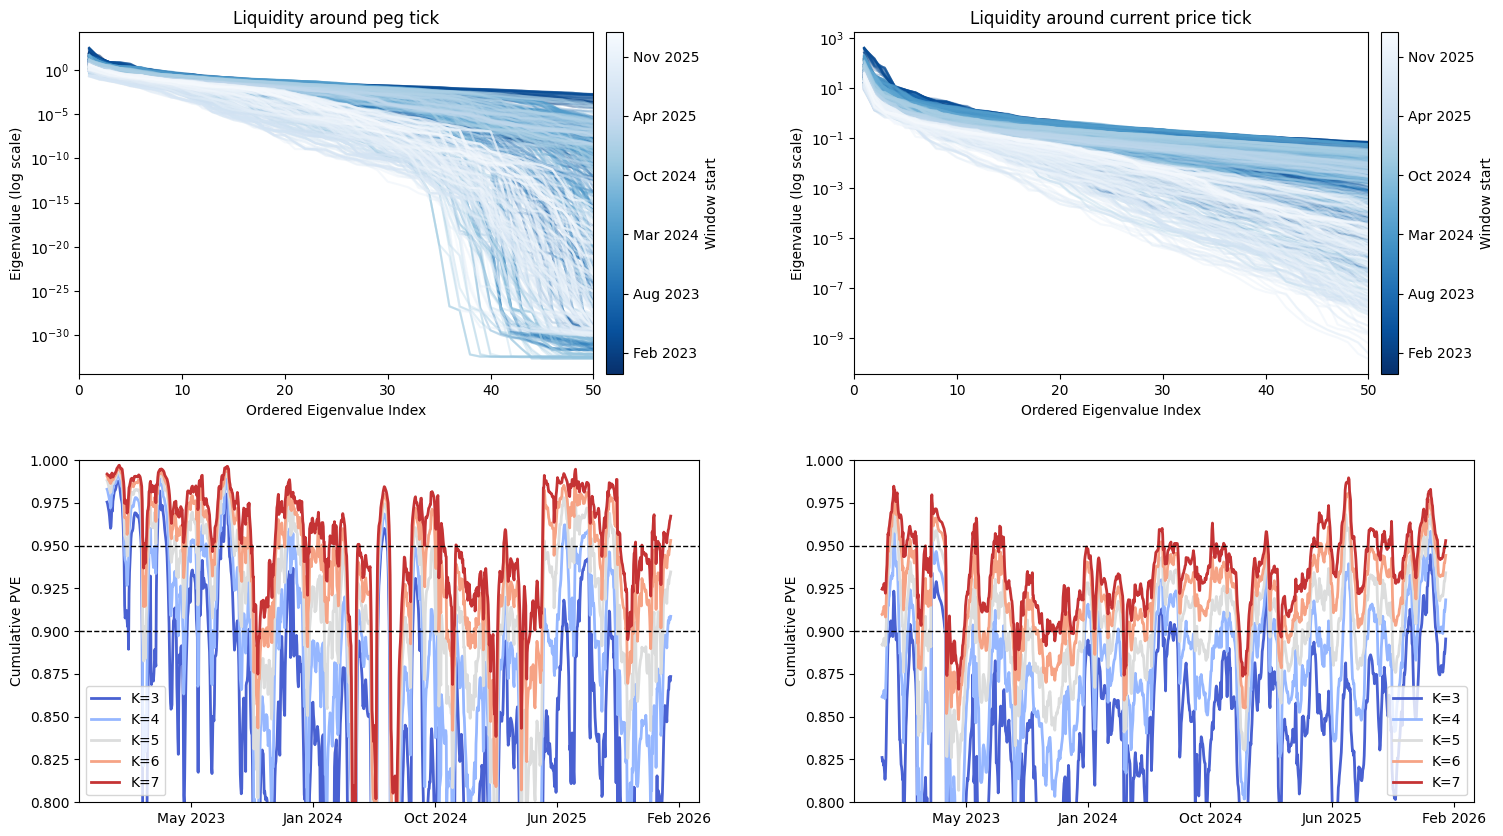

In [ ]:
WINDOW_TICKS = 50                
LIQ_COL = "active_liquidity_L"            
T = 720                         # rolling window 1 month
STEP = 24                       # advance the rolling window by 1 day
KS = [3, 4, 5, 6, 7]             # ranks for CPVE curves

Y_pegcentered = (d_pegcentered.pivot_table(index="timestamp", columns="tick_norm", values=LIQ_COL, aggfunc="sum")
       .sort_index()
       .sort_index(axis=1))
Y_pegcentered = Y_pegcentered.fillna(0.0)
Ylog_pegcentered = np.log1p(Y_pegcentered)
_ , t_end, eigs_arr_pegcentered, vecs_arr_pegcentered, cpve_pegcentered = utils.rolling_pca_eigs_and_cpve(Ylog_pegcentered, T=T, step=STEP, Ks=KS)

Y_pricecentered = (d_pricecentered.pivot_table(index="timestamp", columns="tick_norm", values=LIQ_COL, aggfunc="sum")
       .sort_index()
       .sort_index(axis=1))
Y_pricecentered = Y_pricecentered.fillna(0.0)
Ylog_pricecentered = np.log1p(Y_pricecentered)
_ , _, eigs_arr_pricecentered, vecs_arr_pricecentered, cpve_pricecentered = utils.rolling_pca_eigs_and_cpve(Ylog_pricecentered, T=T, step=STEP, Ks=KS)

fig = plt.figure(figsize=(18, 10))

gs = fig.add_gridspec(
    nrows=2, ncols=2,
    height_ratios=[1, 1],
    hspace=0.25, wspace=0.25
)

ax_top_pegcentered   = fig.add_subplot(gs[0, 0])
ax_bot_pegcentered   = fig.add_subplot(gs[1, 0])

ax_top_pricecentered = fig.add_subplot(gs[0, 1])
ax_bot_pricecentered = fig.add_subplot(gs[1, 1])

t_num = mdates.date2num(t_end.to_pydatetime())
norm = Normalize(vmin=t_num.min(), vmax=t_num.max())
cmap = plt.cm.Blues_r
sm = ScalarMappable(norm=norm, cmap=cmap)

p = eigs_arr_pegcentered.shape[1]
idx = np.arange(1, p + 1)

for i in range(eigs_arr_pegcentered.shape[0]):
    ax_top_pegcentered.plot(idx[:50], eigs_arr_pegcentered[i][:50], color=cmap(norm(t_num[i])), lw=1.5, alpha=0.25)
ax_top_pegcentered.set_yscale("log")
ax_top_pegcentered.set_ylabel("Eigenvalue (log scale)")
ax_top_pegcentered.set_xlabel("Ordered Eigenvalue Index")
ax_top_pegcentered.set_xlim(0, 50)
ax_top_pegcentered.set_title("Liquidity around peg tick")
cbar = fig.colorbar(sm, ax=ax_top_pegcentered, pad=0.02)
cbar.ax.yaxis.set_major_formatter(mdates.DateFormatter("%b %Y", tz=mdates.UTC))
cbar.set_label("Window start")

K_colors = plt.cm.coolwarm(np.linspace(0.05, 0.95, len(KS)))
for K, col in zip(KS, K_colors):
    ax_bot_pegcentered.plot(t_end, cpve_pegcentered[K], lw=2.0, color=col, label=f"K={K}")

ax_bot_pegcentered.axhline(0.90, color="k", ls="--", lw=1)
ax_bot_pegcentered.axhline(0.95, color="k", ls="--", lw=1)

ax_bot_pegcentered.set_ylim(0.80, 1.00)
ax_bot_pegcentered.set_ylabel("Cumulative PVE")
ax_bot_pegcentered.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y", tz=mdates.UTC))
ax_bot_pegcentered.legend(loc="best", frameon=True)


p = eigs_arr_pricecentered.shape[1]
idx = np.arange(1, p + 1)

for i in range(eigs_arr_pricecentered.shape[0]):
    ax_top_pricecentered.plot(idx[:50], eigs_arr_pricecentered[i][:50], color=cmap(norm(t_num[i])), lw=1.5, alpha=0.25)
ax_top_pricecentered.set_yscale("log")
ax_top_pricecentered.set_ylabel("Eigenvalue (log scale)")
ax_top_pricecentered.set_xlabel("Ordered Eigenvalue Index")
ax_top_pricecentered.set_xlim(0, 50)
ax_top_pricecentered.set_title("Liquidity around current price tick")
cbar = fig.colorbar(sm, ax=ax_top_pricecentered, pad=0.02)
cbar.ax.yaxis.set_major_formatter(mdates.DateFormatter("%b %Y", tz=mdates.UTC))
cbar.set_label("Window start")

K_colors = plt.cm.coolwarm(np.linspace(0.05, 0.95, len(KS)))
for K, col in zip(KS, K_colors):
    ax_bot_pricecentered.plot(t_end, cpve_pricecentered[K], lw=2.0, color=col, label=f"K={K}")

ax_bot_pricecentered.axhline(0.90, color="k", ls="--", lw=1)
ax_bot_pricecentered.axhline(0.95, color="k", ls="--", lw=1)

ax_bot_pricecentered.set_ylim(0.80, 1.00)
ax_bot_pricecentered.set_ylabel("Cumulative PVE")
ax_bot_pricecentered.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y", tz=mdates.UTC))
ax_bot_pricecentered.legend(loc="best", frameon=True)

ax_bot_pricecentered.xaxis.set_major_locator(plt.MaxNLocator(6))
ax_bot_pegcentered.xaxis.set_major_locator(plt.MaxNLocator(6))
plt.savefig('./uniswap_liquidity_pca_analysis.png', dpi=300, transparent = True, bbox_inches = 'tight')

# Time evolution of Principal components

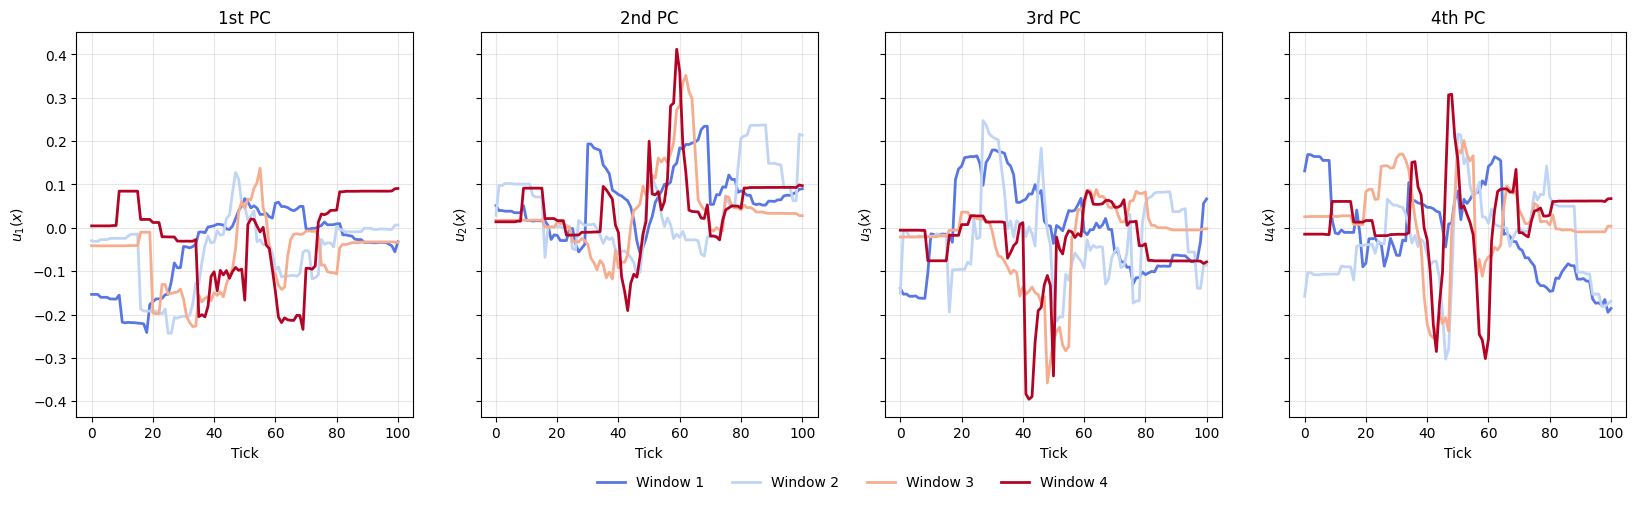

In [23]:
def align_pc_signs(vecs_arr):
    """
    Align signs of rolling PCA eigenvectors so they are consistent over time.
    vecs_arr: (n_windows, K, p)
    """
    V = vecs_arr.copy()
    nW, K, p = V.shape

    for i in range(1, nW):
        for k in range(K):
            # if direction changed (dot < 0), flip
            if np.dot(V[i-1, k, :], V[i, k, :]) < 0:
                V[i, k, :] *= -1.0
    return V

Y_data = np.log1p(Y_pegcentered.values)
n_rows = Y_data.shape[0]
window_size = n_rows // 4
windows = [
    Y_data[i*window_size:(i+1)*window_size, :]
    for i in range(4)
]


fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

V = []; betas = []
for window_idx, window_data in enumerate(windows):
    m, U, B, Y_hat, R, eigvals, cpve = utils.pca_factor_decomposition(window_data, K=5, center=True)
    V.append(U)
    betas.append(B)
V = align_pc_signs(np.array(V))
betas = np.array(betas)

for window_idx, window_data in enumerate(windows):
    axs[0].plot(V[window_idx,0, :], lw=2, color = matplotlib.cm.coolwarm(np.linspace(0.1, 1, 4)[window_idx]))
    axs[0].set_title(f'1st PC')
    axs[0].set_xlabel(r'Tick')
    axs[0].set_ylabel(r'$u_1(x)$')
    axs[0].grid(True, alpha=0.3)
    axs[1].plot(V[window_idx,1, :], lw=2, color = matplotlib.cm.coolwarm(np.linspace(0.1, 1, 4)[window_idx]))
    axs[1].set_title(f'2nd PC')
    axs[1].set_xlabel(r'Tick')
    axs[1].set_ylabel(r'$u_2(x)$')
    axs[1].grid(True, alpha=0.3)
    axs[2].plot(V[window_idx, 2, :], lw=2, color = matplotlib.cm.coolwarm(np.linspace(0.1, 1, 4)[window_idx]))
    axs[2].set_title(f'3rd PC')
    axs[2].set_xlabel(r'Tick')
    axs[2].set_ylabel(r'$u_3(x)$')
    axs[2].grid(True, alpha=0.3)
    axs[3].plot(V[window_idx, 3, :], lw=2, color = matplotlib.cm.coolwarm(np.linspace(0.1, 1, 4)[window_idx]))
    axs[3].set_title(f'4th PC')
    axs[3].set_xlabel(r'Tick')
    axs[3].set_ylabel(r'$u_4(x)$')
    axs[3].grid(True, alpha=0.3)
    axs[2].legend([f'Window {i+1}' for i in range(4)], ncols = 4, bbox_to_anchor=(0.7, -.12), frameon=False)

plt.savefig('./4PCs_pegcentered.png', dpi = 300, transparent = True, bbox_inches = 'tight')

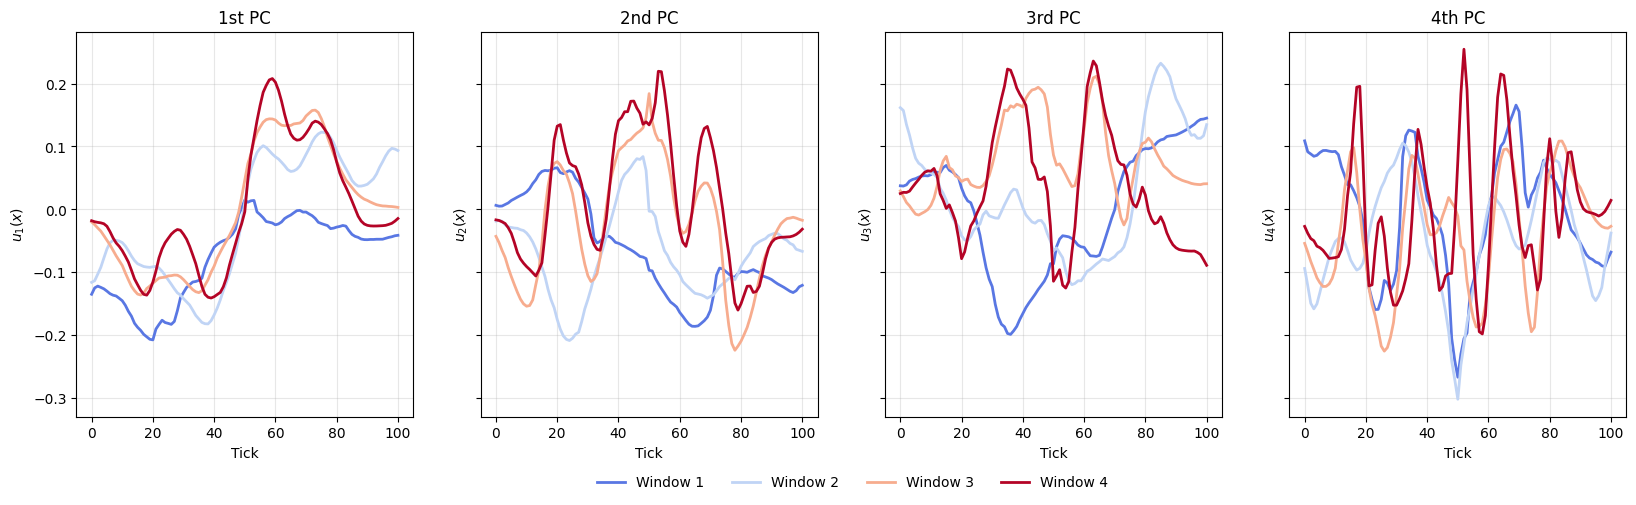

In [25]:
Y_data = np.log1p(Y_pricecentered.values)
n_rows = Y_data.shape[0]
window_size = n_rows // 4
windows = [
    Y_data[i*window_size:(i+1)*window_size, :] if i < 3 else Y_data[i*window_size:, :]
    for i in range(4)
]


fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

V = []
for window_idx, window_data in enumerate(windows):
    m, U, B, Y_hat, R, eigvals, cpve = utils.pca_factor_decomposition(window_data, K=5, center=True)
    V.append(U)
    
V = align_pc_signs(np.array(V))
    
for window_idx, window_data in enumerate(windows):
    axs[0].plot(V[window_idx,0, :], lw=2, color = matplotlib.cm.coolwarm(np.linspace(0.1, 1, 4)[window_idx]))
    axs[0].set_title(f'1st PC')
    axs[0].set_xlabel(r'Tick')
    axs[0].set_ylabel(r'$u_1(x)$')
    axs[0].grid(True, alpha=0.3)
    axs[1].plot(V[window_idx,1, :], lw=2, color = matplotlib.cm.coolwarm(np.linspace(0.1, 1, 4)[window_idx]))
    axs[1].set_title(f'2nd PC')
    axs[1].set_xlabel(r'Tick')
    axs[1].set_ylabel(r'$u_2(x)$')
    axs[1].grid(True, alpha=0.3)
    axs[2].plot(V[window_idx, 2, :], lw=2, color = matplotlib.cm.coolwarm(np.linspace(0.1, 1, 4)[window_idx]))
    axs[2].set_title(f'3rd PC')
    axs[2].set_xlabel(r'Tick')
    axs[2].set_ylabel(r'$u_3(x)$')
    axs[2].grid(True, alpha=0.3)
    axs[3].plot(V[window_idx, 3, :], lw=2, color = matplotlib.cm.coolwarm(np.linspace(0.1, 1, 4)[window_idx]))
    axs[3].set_title(f'4th PC')
    axs[3].set_xlabel(r'Tick')
    axs[3].set_ylabel(r'$u_4(x)$')
    axs[3].grid(True, alpha=0.3)
    axs[2].legend([f'Window {i+1}' for i in range(4)], ncols = 4, bbox_to_anchor=(0.7, -.12), frameon=False)
plt.savefig('./4PCs_pricecentered.png', dpi = 300, transparent = True, bbox_inches = 'tight')